In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor, AutoModelForDepthEstimation, ViTImageProcessor
from dataset import PairedImagesDataset, sample_cvusa_images, get_transforms, denormalize
from model import CrossviewModel, CosineSimilarityLoss, get_combined_embedding_visualization_all, get_processors

In [2]:
# Sample paired images
dataset_path = r"D:\CVUSA\CVPR_subset"
train_filenames, val_filenames = sample_cvusa_images(dataset_path, sample_percentage=0.2, split_ratio=0.8, groundtype='panos')

# Settings
image_size = 224
aerial_scaling = 2
provide_paths = False
BATCH_SIZE = 1

backbone = 'dinov3'

# Get the processor and transforms
processors = get_processors(backbone)
transform_ground, transform_aerial = get_transforms(processors, image_size, aerial_scaling)

# Instantiate the dataset and dataloader
paired_dataset = PairedImagesDataset(train_filenames, transform_aerial=transform_aerial, transform_ground=transform_ground, cutout_from_pano=True)
data_loader = DataLoader(paired_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define the Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load IndoorOutdoorClassifier
from inoutdoor import IndoorOutdoorClassifier
indoor_outdoor_classifier = IndoorOutdoorClassifier().to(device)

# Load the Model
model = CrossviewModel(backbone=backbone, frozen=True).to(device)
model.show()

panos
Using device: cuda



CrossviewModel(
  (model): DINOv3ViTModel(
    (embeddings): DINOv3ViTEmbeddings(
      (patch_embeddings): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (rope_embeddings): DINOv3ViTRopePositionEmbedding()
    (layer): ModuleList(
      (0-23): 24 x DINOv3ViTLayer(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attention): DINOv3ViTAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (layer_scale1): DINOv3ViTLayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): DINOv3ViTMLP(
          (up_proj): Linear(in_features=1024, out_features=4096, bias=True)
        

fov [tensor([90]), tensor([180])]
yaw tensor([187])
pitch tensor([90])
ground tokens shape: torch.Size([1, 196, 1024])
aerial tokens shape: torch.Size([1, 196, 1024])
num_patches_ground:  196
num_patches_aerial:  196
Ground image pixel values (min, max): 0.0 1.0
Aerial image pixel values (min, max): 0.0 1.0
Outdoor Probability: 99.9%


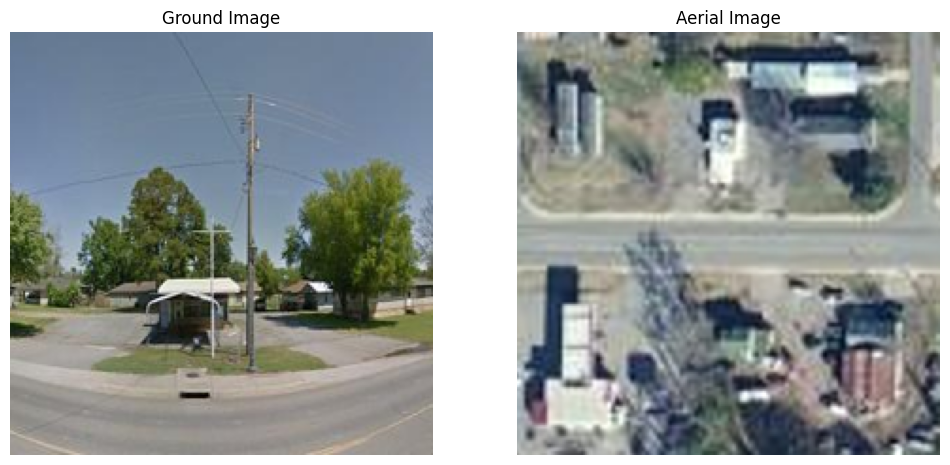

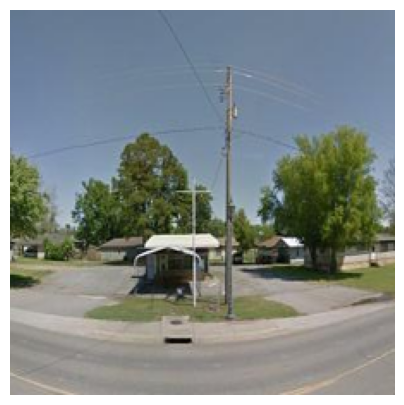

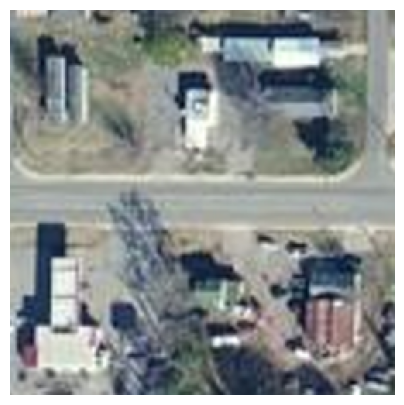

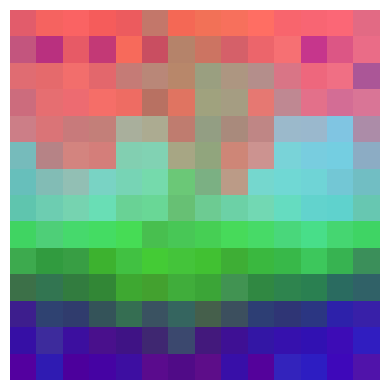

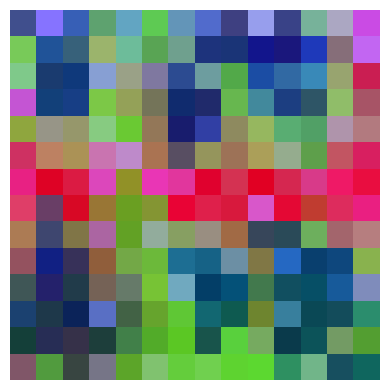

In [3]:
# Load a single pair of images
ground_image, aerial_image, fov, yaw, pitch = next(iter(data_loader))
ground_image = ground_image.to(device)
aerial_image = aerial_image.to(device)

print("fov", fov)
print("yaw", yaw)
print("pitch", pitch)

# Compute the output of the model
ground_tokens, aerial_tokens = model(ground_image, aerial_image, debug=True)

print("ground tokens shape:", ground_tokens.shape)
print("aerial tokens shape:", aerial_tokens.shape)

# Calculate the number of patches for ground and aerial images
num_patches_ground = (ground_image.shape[-1] // model.patch_size) * (ground_image.shape[-2] // model.patch_size)
num_patches_aerial = (aerial_image.shape[-1] // model.patch_size) * (aerial_image.shape[-2] // model.patch_size)
print("num_patches_ground: ", num_patches_ground)
print("num_patches_aerial: ", num_patches_aerial)

ground_image_denorm = denormalize(ground_image.squeeze(), processors[0])
aerial_image_denorm = denormalize(aerial_image.squeeze(), processors[1])

# Convert images to numpy for visualization
ground_image_np = ground_image_denorm.permute(1, 2, 0).detach().cpu().numpy()
aerial_image_np = aerial_image_denorm.permute(1, 2, 0).detach().cpu().numpy()

print("Ground image pixel values (min, max):", ground_image_np.min(), ground_image_np.max())
print("Aerial image pixel values (min, max):", aerial_image_np.min(), aerial_image_np.max())

# Check for Indoor or Outdoor Image
with torch.no_grad():
    ground_preds = indoor_outdoor_classifier(ground_image)

print(f"Outdoor Probability: {ground_preds['Outdoor']*100}%")

# Plot the ground image and aerial image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ground_image_np)
ax[0].set_title("Ground Image")
ax[0].axis('off')
ax[1].imshow(aerial_image_np)
ax[1].set_title("Aerial Image")
ax[1].axis('off')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ground_image_np)
ax.axis('off')
plt.savefig(os.path.join("images", "ground_image.png"), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(aerial_image_np)
ax.axis('off')
plt.savefig(os.path.join("images", "aerial_image.png"), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

ground_vis_tokens = model.show_tokens(ground_tokens, mode='save', results_path=os.path.join("images", "ground_tokens.png"), return_tokens=True)

aerial_vis_tokens = model.show_tokens(aerial_tokens, mode='save', results_path=os.path.join("images", "aerial_tokens.png"), return_tokens=True)

In [17]:
# ground_image_vis = ground_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
# aerial_image_vis = aerial_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
# ground_image_vis = ground_image_vis.astype(np.uint8)
# aerial_image_vis = aerial_image_vis.astype(np.uint8)

ground_image_vis = ground_image_np * 255
aerial_image_vis = aerial_image_np * 255
ground_image_vis = ground_image_vis.astype(np.uint8)
aerial_image_vis = aerial_image_vis.astype(np.uint8)

# Extract features
image_tensor1, grid_size1, resize_scale1 = model.prepare_image(ground_image_vis, patch_size=model.patch_size)
image_tensor2, grid_size2, resize_scale2 = model.prepare_image(aerial_image_vis, patch_size=model.patch_size)
grid_size1 = (grid_size1[0], grid_size1[1])
grid_size2 = (grid_size2[0], grid_size2[1])
tokens_1 = ground_tokens.squeeze(0).detach().cpu().numpy()
tokens_2 = aerial_tokens.squeeze(0).detach().cpu().numpy()
grid_size4 = grid_size2
grid_size2_reduced = grid_size2

# More info
print("ground_image shape:", ground_image.shape)
print("aerial_image shape:", aerial_image.shape)
print("tokens_1 shape:", tokens_1.shape)
print("tokens_2 shape:", tokens_2.shape)
print("grid_size1:", grid_size1)
print("grid_size2:", grid_size2)
print("grid_size2_reduced:", grid_size2_reduced)
print("resize_scale1:", resize_scale1)
print("resize_scale2:", resize_scale2)

# # Visualization - Baseline
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 15))
# ax1.imshow(ground_image_vis)
# ax1.set_title('Ground Image')
# ax2.imshow(aerial_image_vis)
# ax2.set_title('Aerial Image')
# vis_combined1, vis_combined2, vis_combined3, vis_combined4 = get_combined_embedding_visualization_all(dm.extract_features(image_tensor1), dm.extract_features(image_tensor2), tokens_1, tokens_2, grid_size1, grid_size2, grid_size1, grid_size2_reduced, debug=True)
# ax3.imshow(vis_combined1)
# ax3.set_title('Combined Features 1 - Reference')
# ax4.imshow(vis_combined2)
# ax4.set_title('Combined Features 2 - Reference')
# ax5.imshow(vis_combined3)
# ax5.set_title('Combined Features 1')
# ax6.imshow(vis_combined4)
# ax6.set_title('Combined Features 2')
# fig.suptitle("Common Baseline for All Images + Reference")
# fig.tight_layout()

# Visualization - Baseline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 15))
ax1.imshow(ground_image_vis)
ax1.set_title('Ground Image')
ax2.imshow(aerial_image_vis)
ax1.axis('off')
ax2.set_title('Aerial Image')
vis_combined1, vis_combined2 = model.get_combined_embedding_visualization(tokens_1, tokens_2, grid_size1, grid_size2_reduced)
ax2.axis('off')
ax3.imshow(vis_combined1)
ax3.set_title('Features 1')
ax3.axis('off')
ax4.imshow(vis_combined2)
ax4.set_title('Features 2')
ax4.axis('off')
fig.suptitle("Common Baseline for Image Row")
fig.tight_layout()

AttributeError: 'SiglipForImageClassification' object has no attribute 'prepare_image'

In [5]:
from PIL import Image
from model import CrossviewModel
import torch.nn.functional as F
import torch
from transformers import AutoImageProcessor, AutoModel
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrossviewModel(backbone='dinov2', frozen=True).to(device)

hf_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
hf_model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)

# assume model_hub: torch.hub DINOv2 loaded and model_hf loaded
img = Image.open("test.png").convert("RGB")

transform_aerial = transforms.Compose([
    transforms.Resize(
        hf_processor.size["shortest_edge"] 
            if "shortest_edge" in hf_processor.size 
            else tuple(hf_processor.size.values()),
        interpolation=transforms.InterpolationMode.BICUBIC,
        antialias=True
    ),
    transforms.CenterCrop(hf_processor.crop_size["height"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=hf_processor.image_mean,
                         std=hf_processor.image_std)
])

# hub preprocessing (your Dinov2Matcher.transform)
img_tensor = transform_aerial(img).unsqueeze(0).to(device)

# HF preprocessing
inputs = hf_processor(images=img, return_tensors="pt").to(device)

with torch.no_grad():
    tokens_hub = model(img_tensor, img_tensor)[0]  # [1, 1+N, C]
    tokens_hf = hf_model(**inputs).last_hidden_state  # [1, 1+num_reg+N, C]

# align indices (skip register tokens if present)
tokens_hub_patches = tokens_hub
num_reg = getattr(hf_model.config, "num_register_tokens", 0)
print("num_reg:", num_reg)  # num_reg = 0 for dinov2-base
tokens_hf_patches = tokens_hf[:, 1+num_reg:, :]

# normalize and compute token cos similarity mean
th = F.normalize(tokens_hub_patches, dim=-1).cpu()
tf = F.normalize(tokens_hf_patches, dim=-1).cpu()

print("th shape:", th.shape)
print("tf shape:", tf.shape)

# resize to same N if needed, or just compare first min(N)
Nmin = min(th.shape[1], tf.shape[1])
sim = F.cosine_similarity(th[:, :Nmin, :], tf[:, :Nmin, :], dim=-1).mean()
print("mean token cos sim:", sim.item())


Using cache found in C:\Users\russ_le/.cache\torch\hub\facebookresearch_dinov2_main
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


num_reg: 0
th shape: torch.Size([1, 256, 768])
tf shape: torch.Size([1, 256, 768])
mean token cos sim: 1.0


 ?> Using provider CPUExecutionProvider
 -> Loading the model
 ?> The model is valid!


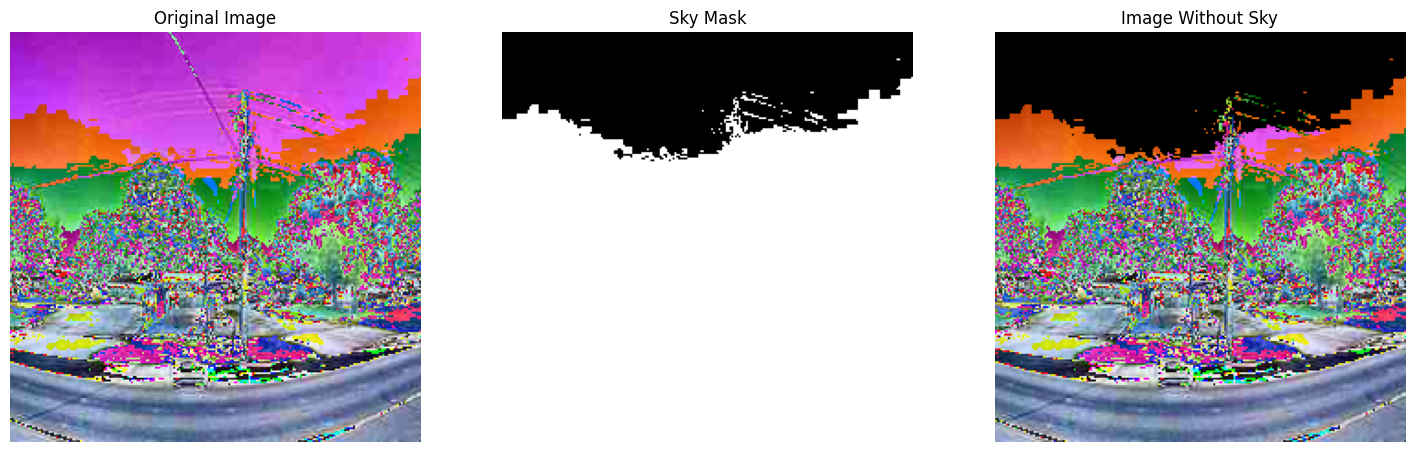

In [6]:
from skyfilter import SkyFilter
from apply_method import apply_sky_filter

# Initialize the sky filter
sky_filter = SkyFilter()

# Apply the sky filter
ground_image_no_sky, sky_mask, grid_mask = apply_sky_filter(sky_filter, ground_image_vis, grid_size1[0], debug=False)

# Visualize the original image, mask, and the sky-removed image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(ground_image_vis)
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(sky_mask, cmap='gray')
ax2.set_title("Sky Mask")
ax2.axis('off')

ax3.imshow(ground_image_no_sky)
ax3.set_title("Image Without Sky")
ax3.axis('off')

plt.show()

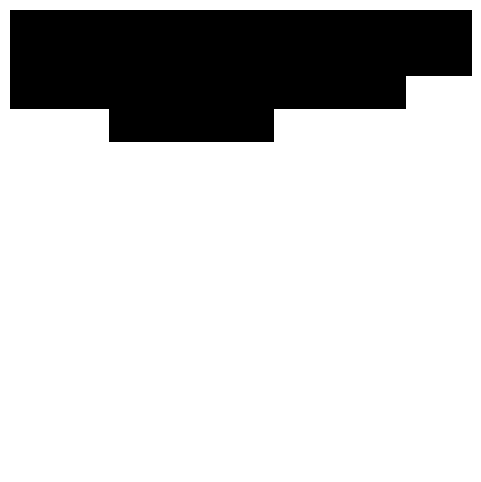

In [7]:
# Define the grid size
grid_size = grid_size1[0]

# Dimensions of the image
height, width = ground_image_no_sky.shape[:2]

# Calculate the size of each grid cell
cell_height = height // grid_size
cell_width = width // grid_size

# Initialize the grid mask
grid_mask = np.zeros((grid_size, grid_size), dtype=np.uint8)

# Loop over each cell in the grid
for i in range(grid_size):
    for j in range(grid_size):
        # Define the region of interest (ROI) for this cell
        start_x = j * cell_width
        start_y = i * cell_height
        end_x = (j + 1) * cell_width if j < grid_size - 1 else width
        end_y = (i + 1) * cell_height if i < grid_size - 1 else height
        
        # Extract the cell from the sky mask
        cell = sky_mask[start_y:end_y, start_x:end_x]
        
        # Apply majority voting: if more than half of the cell is sky, mark it as sky
        if np.mean(cell) > 127:  # Since the mask is binary, 127 is the midpoint
            grid_mask[i, j] = 1  # Mark as ground
        else:
            grid_mask[i, j] = 0  # Mark as ground

# Visualize the grid mask
plt.figure(figsize=(6, 6))
plt.imshow(grid_mask, cmap='gray')
# plt.title("Grid Mask")
plt.axis('off')
plt.show()

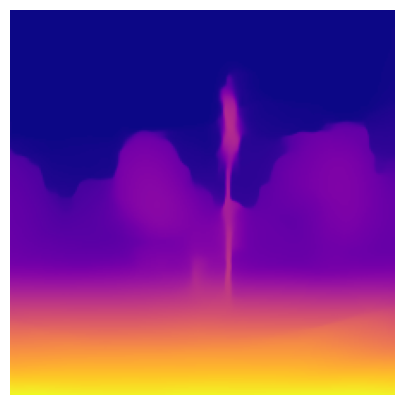

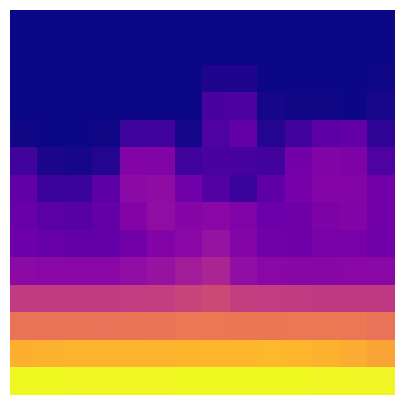

In [8]:
from apply_method import apply_depth_estimation

image_processor_depth = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

depth_map, depth_map_grid = apply_depth_estimation(depth_model, image_processor_depth, ground_image_no_sky, grid_size=grid_size, debug=False)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(depth_map, cmap='plasma')
ax.axis('off')
plt.savefig(os.path.join("images", "depth_map.png"), dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(depth_map_grid, cmap='plasma')
ax.axis('off')
plt.savefig(os.path.join("images", "depth_map.png"), dpi=300, bbox_inches='tight')
plt.show()

normalized_features1.shape: (196, 1024)
normalized_features2.shape: (196, 1024)
grid_size: 14
averaged_vertical_tokens.shape: (14, 1024)
averaged_radial_tokens.shape: (56, 1024)
Min Distance: 1.0711 	Best Orientation: 0.0°
Min Distance: 1.0711 	Best Orientation: 6.428571428571429°
Min Distance: 1.0711 	Best Orientation: 12.857142857142858°
Min Distance: 1.0711 	Best Orientation: 19.285714285714285°
Min Distance: 1.0711 	Best Orientation: 25.714285714285715°
Min Distance: 1.0711 	Best Orientation: 32.142857142857146°
Min Distance: 1.0711 	Best Orientation: 38.57142857142857°
Min Distance: 1.0711 	Best Orientation: 45.0°
Min Distance: 1.0711 	Best Orientation: 51.42857142857143°
Confidence: 1.7257


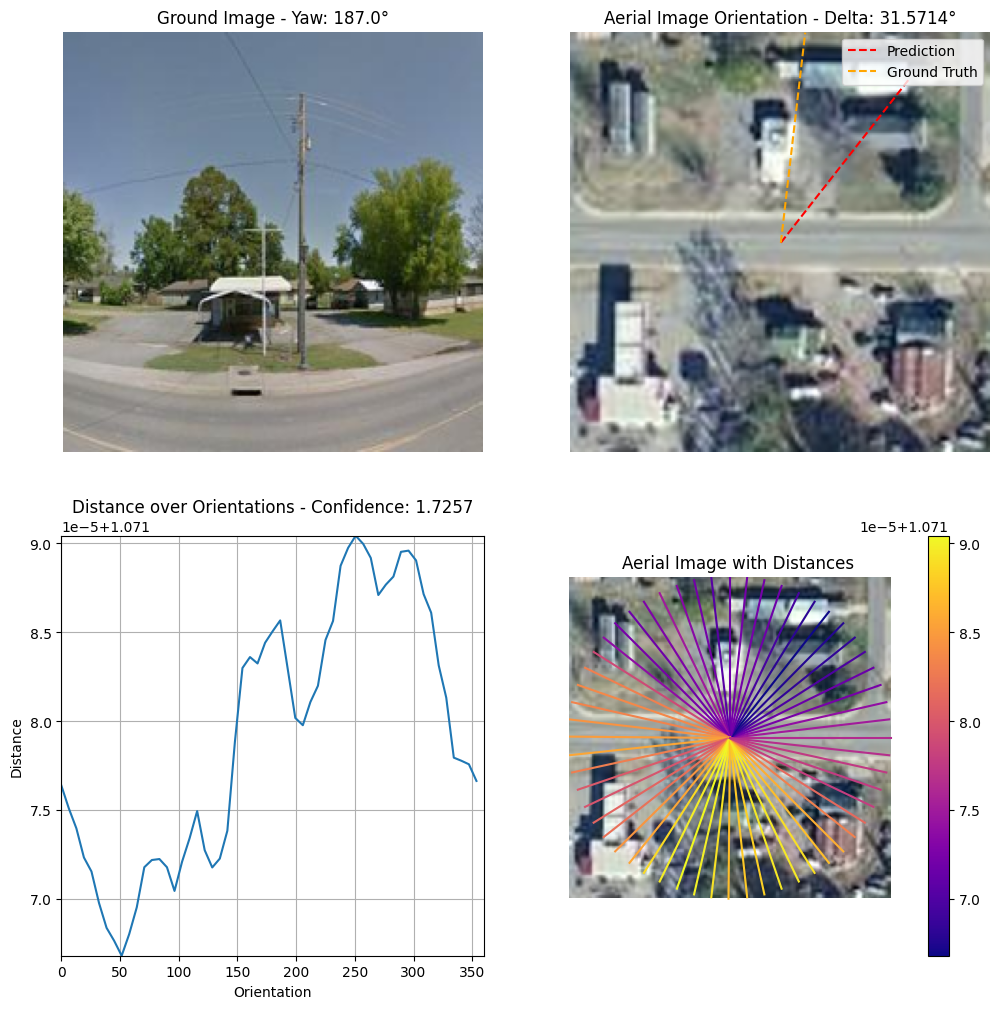

In [9]:
from apply_method import get_direction_tokens
from model import CosineSimilarityLoss, CosineSimilarityLossCustom
from sklearn.preprocessing import normalize

# Normalize the features
normalized_features1 = normalize(tokens_1, axis=1)
normalized_features2 = normalize(tokens_2, axis=1)
print("normalized_features1.shape:", normalized_features1.shape)
print("normalized_features2.shape:", normalized_features2.shape)
print("grid_size:", grid_size)

# Create results directory if it doesn't exist
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

image_span = 90                     # horizontal fov in degrees
angle_step = image_span / grid_size

# Compute Averaged Tokens using the weight vector, excluding sky tokens
averaged_vertical_tokens = []
for i in range(grid_size):
    vertical_tokens, indices = get_direction_tokens(normalized_features1, vertical_idx=i, grid_size=grid_size)
    valid_tokens = []
    valid_weights = []
    for token, (y, x) in zip(vertical_tokens, indices):
        if grid_mask[y, x] == 1:  # 1 indicates ground, 0 indicates sky
            valid_tokens.append(token)
            valid_weights.append(1.0)  # You can adjust the weights if needed
    
    if valid_tokens:
        valid_tokens = np.array(valid_tokens)
        valid_weights = np.array(valid_weights)
        valid_weights /= np.sum(valid_weights)  # Normalize the weights
        
        # Calculate weighted average only on valid (non-sky) tokens
        weighted_avg = np.average(valid_tokens, axis=0, weights=valid_weights)
        averaged_vertical_tokens.append(weighted_avg)
    else:
        # If no valid tokens are found (i.e., entire column is sky), append a zero vector or any placeholder
        averaged_vertical_tokens.append(np.zeros_like(vertical_tokens[0]))
averaged_vertical_tokens = np.array(averaged_vertical_tokens)


averaged_radial_tokens = []
for beta in np.arange(0, 360, angle_step):
    radial_tokens, _ = get_direction_tokens(normalized_features2, angle=beta, grid_size=grid_size)
    # increasing_weights = np.linspace(0.1, 1, len(radial_tokens))
    increasing_weights = np.linspace(1, 1, len(radial_tokens))
    increasing_weights /= np.sum(increasing_weights)
    weighted_avg = np.average(radial_tokens, axis=0, weights=increasing_weights)
    averaged_radial_tokens.append(weighted_avg)
averaged_radial_tokens = np.array(averaged_radial_tokens)

print("averaged_vertical_tokens.shape:", averaged_vertical_tokens.shape)
print("averaged_radial_tokens.shape:", averaged_radial_tokens.shape)

# Function to calculate global minimum cosine distance
def find_alignment(averaged_vertical_tokens, averaged_radial_tokens, grid_size, image_span):
    
    angle_step = image_span / grid_size
    min_distance = float('inf')
    distances = []

    loss = CosineSimilarityLossCustom()

    for j, beta in enumerate(np.arange(0, 360, angle_step)):
        cone_distance = 0
        for i in range(grid_size+1):

            vertical_token = averaged_vertical_tokens[(grid_size-1)-i]
            radial_token = averaged_radial_tokens[int(j + i - grid_size/2) % averaged_radial_tokens.shape[0]]
            # print(f"beta: {beta:.2f} \tangle: {(j + i - grid_size/2)*angle_step} \tindex: {int(j + i - grid_size/2) % averaged_radial_tokens.shape[0]}")       

            # cone_distance += (1 - np.dot(vertical_token, radial_token))  # Cosine distance
            cone_distance += loss(vertical_token, radial_token)
            # cone_distance += np.linalg.norm(vertical_token - radial_token)  # Euclidean distance

        cone_distance /= grid_size
        if cone_distance < min_distance:
            min_distance = cone_distance
            best_orientation = beta
            print(f"Min Distance: {min_distance:.4f} \tBest Orientation: {best_orientation}°")
        distances.append(cone_distance)

    # Compute confidence
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    confidence = (mean_distance - min_distance) / std_distance  # Z-score

    return best_orientation, distances, min_distance, confidence


# Find the best alignment
best_orientation, distances, min_distance, confidence = find_alignment(averaged_vertical_tokens, averaged_radial_tokens, grid_size, image_span)

print(f"Confidence: {confidence:.4f}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

ax1.imshow(ground_image_np)
ax1.set_title("Ground Image - Yaw: {:.1f}°".format(yaw[0]))
ax1.axis('off')

ax2.imshow(aerial_image_np)
radius = aerial_image_np.shape[0] // 2
center = (aerial_image_np.shape[1] // 2, aerial_image_np.shape[0] // 2)
end_x = int(center[0] + radius * np.cos(np.deg2rad(best_orientation)))
end_y = int(center[1] - radius * np.sin(np.deg2rad(best_orientation)))
end_x_GT = int(center[0] + radius * np.cos(np.deg2rad(90 - (yaw - 180))))
end_y_GT = int(center[1] - radius * np.sin(np.deg2rad(90 - (yaw - 180))))
line_pred = ax2.plot([center[0], end_x], [center[1], end_y], color='red', linestyle='--', label='Prediction')
line_gt = ax2.plot([center[0], end_x_GT], [center[1], end_y_GT], color='orange', linestyle='--', label='Ground Truth')
delta_yaw = ((90 - (yaw[0] - 180)) - best_orientation) % 180
if delta_yaw < 0:
    delta_yaw += 180
ax2.set_title("Aerial Image Orientation - Delta: {:.4f}°".format(delta_yaw))
ax2.legend(loc='upper right')
ax2.axis('off')

ax3.plot(np.arange(0, 360, angle_step), distances)
ax3.set_title("Distance over Orientations - Confidence: {:.4f}".format(confidence))
ax3.grid(True)
ax3.set_xlabel('Orientation')
ax3.set_ylabel('Distance')
ax3.set_xlim(0, 360)
ax3.set_ylim(min(distances), max(distances))

ax4.imshow(aerial_image_np)
radius = aerial_image_np.shape[0] // 2
center = (aerial_image_np.shape[1] // 2, aerial_image_np.shape[0] // 2)
min_dist = min(distances)
max_dist = max(distances)
for j, beta in enumerate(np.arange(0, 360, angle_step)):
    end_x = int(center[0] + radius * np.cos(np.deg2rad(beta)))
    end_y = int(center[1] - radius * np.sin(np.deg2rad(beta)))
    color = plt.cm.plasma((distances[j] - min_dist) / (max_dist - min_dist))  # Normalize distances for color map
    ax4.plot([center[0], end_x], [center[1], end_y], color=color)
ax4.set_title("Aerial Image with Distances")
ax4.axis('off')

norm = plt.Normalize(min_dist, max_dist)
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax4)

# Determine the next available file number
file_count = len([name for name in os.listdir(results_dir) if name.startswith("summary") and name.endswith(".png")])
file_path = os.path.join(results_dir, f"summary_{file_count}.png")

# Save the figure
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8284271247461903..1.4142135623730951].


Tokenized depth visualization saved to: images\tokenized_depth_visualization.png


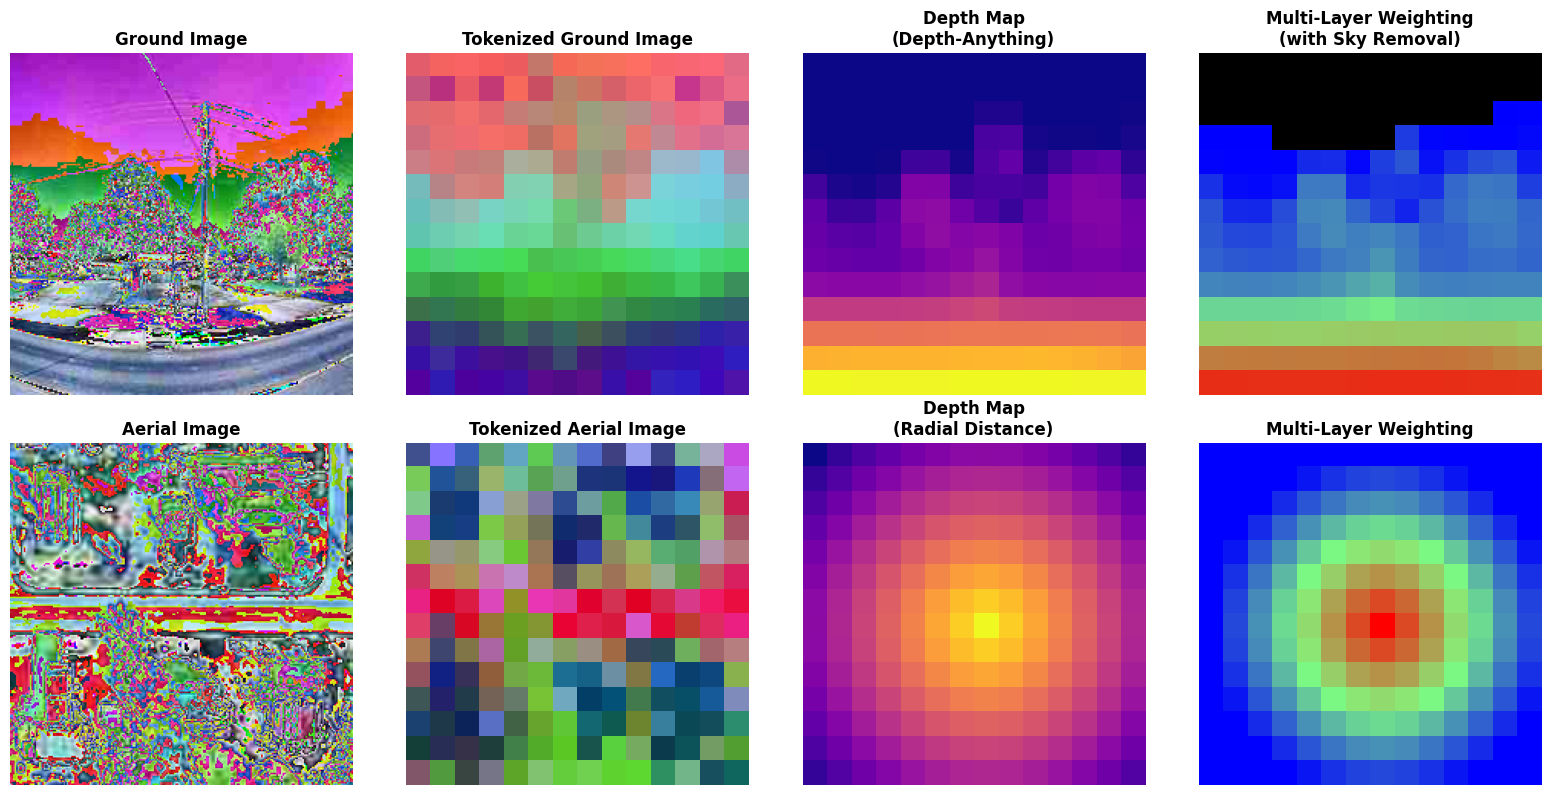

In [10]:
# Tokenized Depth Map Visualization for Paper
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def create_tokenized_depth_visualization(depth_map_grid, sky_grid, grid_size, save_path=None):
    """
    Creates a comprehensive visualization showing how depth information is tokenized
    and applied to both ground and aerial image tokens for the paper method section.
    """
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: Ground Image Processing
    # Original Ground Image
    axes[0, 0].imshow(ground_image_vis)
    axes[0, 0].set_title('Ground Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    # Tokenized Ground Image
    # axes[0, 1].imshow(vis_combined1)
    axes[0, 1].imshow(ground_vis_tokens.squeeze(0))
    axes[0, 1].set_title('Tokenized Ground Image', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Tokenized Depth Grid
    im1 = axes[0, 2].imshow(depth_map_grid, cmap='plasma', interpolation='nearest')
    axes[0, 2].set_title('Depth Map\n(Depth-Anything)', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    # # Add grid lines to show tokenization
    # for i in range(grid_size + 1):
    #     axes[0, 2].axhline(i - 0.5, color='white', linewidth=0.5, alpha=0.7)
    #     axes[0, 2].axvline(i - 0.5, color='white', linewidth=0.5, alpha=0.7)
    
    # Depth-Weighted Token Visualization
    # Create a visualization showing foreground/middleground/background layers
    depth_layers = np.zeros((grid_size, grid_size, 3))
    for i in range(grid_size):
        for j in range(grid_size):
            if sky_grid[i, j] == 1:  # Non-sky tokens
                d = depth_map_grid[i, j]
                # Foreground (close): Red channel = depth value
                depth_layers[i, j, 0] = d
                # Middleground: Green channel = triangular weighting
                depth_layers[i, j, 1] = 1 - abs(d - 0.5) * 2
                # Background (far): Blue channel = 1 - depth value  
                depth_layers[i, j, 2] = 1 - d
    
    axes[0, 3].imshow(depth_layers)
    axes[0, 3].set_title('Multi-Layer Weighting\n(with Sky Removal)', fontsize=12, fontweight='bold')
    axes[0, 3].axis('off')
    
    # Row 2: Aerial Image Processing
    # Original Aerial Image
    axes[1, 0].imshow(aerial_image_vis)
    axes[1, 0].set_title('Aerial Image', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Radial Distance Map
    center = (grid_size // 2, grid_size // 2)
    radial_distance_grid = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            distance = np.sqrt((i - center[0])**2 + (j - center[1])**2)
            radial_distance_grid[i, j] = distance / (grid_size//2)  # Normalize to [0, 1]
    
    # Tokenized Aerial Image
    # axes[1, 1].imshow(vis_combined2)
    axes[1, 1].imshow(aerial_vis_tokens.squeeze(0))
    axes[1, 1].set_title('Tokenized Aerial Image', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    # # Tokenized Radial Grid with directional arrows
    # axes[1, 2].imshow(radial_distance_grid, cmap='plasma', alpha=0.6, interpolation='nearest')
    
    # # Add radial direction arrows
    # center_x, center_y = grid_size // 2, grid_size // 2
    # angles = np.arange(0, 360, 45)  # Every 45 degrees
    # for angle in angles:
    #     for r in range(1, grid_size // 2):
    #         x = center_x + r * np.cos(np.deg2rad(angle))
    #         y = center_y - r * np.sin(np.deg2rad(angle))
    #         if 0 <= x < grid_size and 0 <= y < grid_size:
    #             # Draw small arrows
    #             dx = 0.3 * np.cos(np.deg2rad(angle))
    #             dy = -0.3 * np.sin(np.deg2rad(angle))
    #             axes[1, 2].arrow(x - dx/2, y - dy/2, dx, dy, 
    #                            head_width=0.1, head_length=0.1, 
    #                            fc='white', ec='white', alpha=0.8)
    
    # axes[1, 2].set_title('Depth Map\n(Radial Distance)', fontsize=12, fontweight='bold')
    # axes[1, 2].axis('off')

    im2 = axes[1, 2].imshow(1 - radial_distance_grid, cmap='plasma', interpolation='nearest')
    axes[1, 2].set_title('Depth Map\n(Radial Distance)', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    # Radial-Weighted Token Visualization
    radial_layers = np.zeros((grid_size, grid_size, 3))
    for i in range(grid_size):
        for j in range(grid_size):
            r = radial_distance_grid[i, j]
            # Foreground (center): Red channel = 1 - radial distance
            radial_layers[i, j, 0] = 1 - r
            # Middleground: Green channel = triangular weighting
            radial_layers[i, j, 1] = 1 - abs(r - 0.5) * 2
            # Background (edge): Blue channel = radial distance
            radial_layers[i, j, 2] = r
    
    axes[1, 3].imshow(radial_layers)
    axes[1, 3].set_title('Multi-Layer Weighting', fontsize=12, fontweight='bold')
    axes[1, 3].axis('off')
    
    # # Add colorbar for depth/distance reference
    # cbar1 = plt.colorbar(im1, ax=axes[0, 2], fraction=0.046, pad=0.04)
    # cbar1.set_label('Depth Value', fontsize=10)
    
    # cbar2 = plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)
    # cbar2.set_label('Radial Distance', fontsize=10)
    
    # # Add row labels
    # axes[0, 0].text(-0.1, 0.5, 'Ground Image\nProcessing', fontsize=14, fontweight='bold', 
    #                transform=axes[0, 0].transAxes, rotation=90, ha='center', va='center')
    # axes[1, 0].text(-0.1, 0.5, 'Aerial Image\nProcessing', fontsize=14, fontweight='bold', 
    #                transform=axes[1, 0].transAxes, rotation=90, ha='center', va='center')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Tokenized depth visualization saved to: {save_path}")
    
    plt.show()
    
    return fig

# Create the visualization
fig = create_tokenized_depth_visualization(
    depth_map_grid, 
    grid_mask, 
    grid_size, 
    save_path=os.path.join("images", "tokenized_depth_visualization.png")
)

Direction visualization saved to: images\rainbow_directions.png


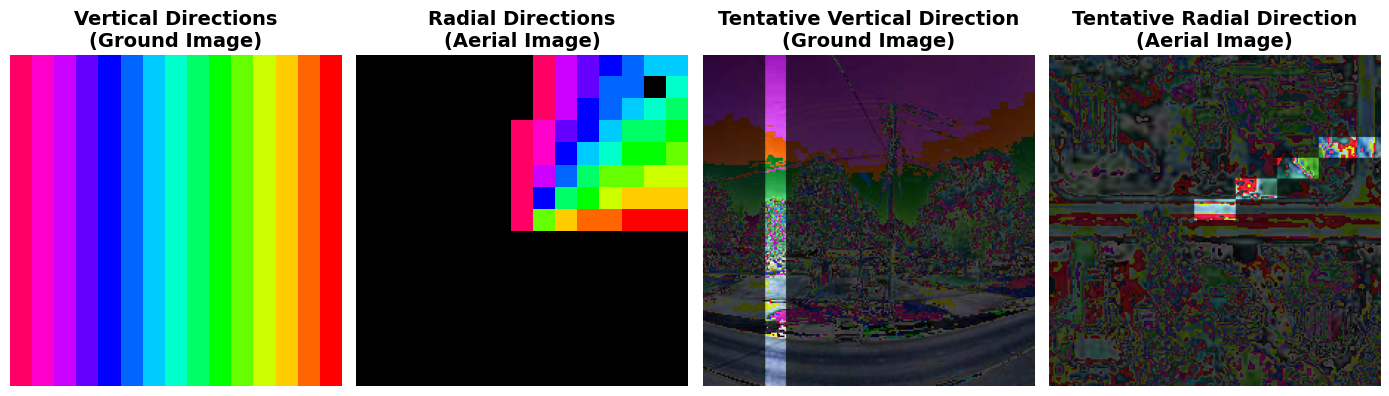

In [11]:
def create_direction_visualization(grid_size, total_directions=16, selected_vertical_index=None, selected_radial_index=None, save_path=None):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import hsv_to_rgb

    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(14, 10))

    # Panel 1: Vertical Directions
    vertical_rainbow = np.zeros((grid_size, grid_size, 3))
    for i in range(grid_size):
        hue = i / grid_size
        color = hsv_to_rgb([hue, 1.0, 1.0])
        vertical_rainbow[:, grid_size - 1 - i] = color
    ax1.imshow(vertical_rainbow)
    ax1.set_title('Vertical Directions\n(Ground Image)', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Panel 2: Radial Directions - Now Symmetrical
    radial_rainbow = np.zeros((grid_size, grid_size, 3))
    angle_step = fov[0].cpu().numpy()[0] / grid_size
    for i in range(grid_size):
        angle = i * angle_step
        # print(f"Angle: {angle}°")
        _, indices = get_direction_tokens(tokens=None, angle=angle, grid_size=grid_size)
        # print(f"Indices for angle {angle}: {indices}")
        # continue
        hue = i / grid_size
        color = hsv_to_rgb([hue, 1.0, 1.0])
        for (y, x) in indices:
            radial_rainbow[y, x] = color
    ax2.imshow(radial_rainbow)
    ax2.set_title('Radial Directions\n(Aerial Image)', fontsize=14, fontweight='bold')
    ax2.axis('off')

    # Prepare for overlays
    image_height, image_width = ground_image_vis.shape[:2]
    cell_height = image_height // grid_size
    cell_width = image_width // grid_size

    # Panel 3: Ground Image with vertical tokens highlighted by index
    ax3.imshow(ground_image_vis)
    fog_overlay3 = np.ones((image_height, image_width, 4)) * [0, 0, 0, 0.7]  # Black fog with alpha=0.7

    column_index = selected_vertical_index if selected_vertical_index is not None else grid_size // 2

    for y in range(grid_size):
        start_y = y * cell_height
        end_y = (y + 1) * cell_height if y < grid_size - 1 else image_height
        start_x = column_index * cell_width
        end_x = (column_index + 1) * cell_width if column_index < grid_size - 1 else image_width
        fog_overlay3[start_y:end_y, start_x:end_x] = [0, 0, 0, 0.0]  # No fog

    ax3.imshow(fog_overlay3)
    ax3.set_title(f'Tentative Vertical Direction\n(Ground Image)', fontsize=14, fontweight='bold')
    ax3.axis('off')

    # Panel 4: Radial Direction - Fog everywhere except radial tokens
    ax4.imshow(aerial_image_vis)
    fog_overlay4 = np.ones((image_height, image_width, 4)) * [0, 0, 0, 0.7]  # Black fog

    radial_index = selected_radial_index if selected_radial_index is not None else 0
    angle = radial_index * angle_step
    _, radial_indices = get_direction_tokens(tokens=None, angle=angle, grid_size=grid_size)

    for (y, x) in radial_indices:
        start_y = y * cell_height
        end_y = (y + 1) * cell_height if y < grid_size - 1 else image_height
        start_x = x * cell_width
        end_x = (x + 1) * cell_width if x < grid_size - 1 else image_width
        fog_overlay4[start_y:end_y, start_x:end_x] = [0, 0, 0, 0.0]  # No fog

    ax4.imshow(fog_overlay4)
    ax4.set_title(f'Tentative Radial Direction\n(Aerial Image)', fontsize=14, fontweight='bold')
    ax4.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Direction visualization saved to: {save_path}")

    plt.show()
    return fig


rainbow_fig = create_direction_visualization(
    grid_size=15,
    total_directions=4*15,
    selected_vertical_index=3,  # Column index you want to highlight
    selected_radial_index=4,    # Index of direction among 16 radial ones
    save_path=os.path.join("images", "rainbow_directions.png")
)



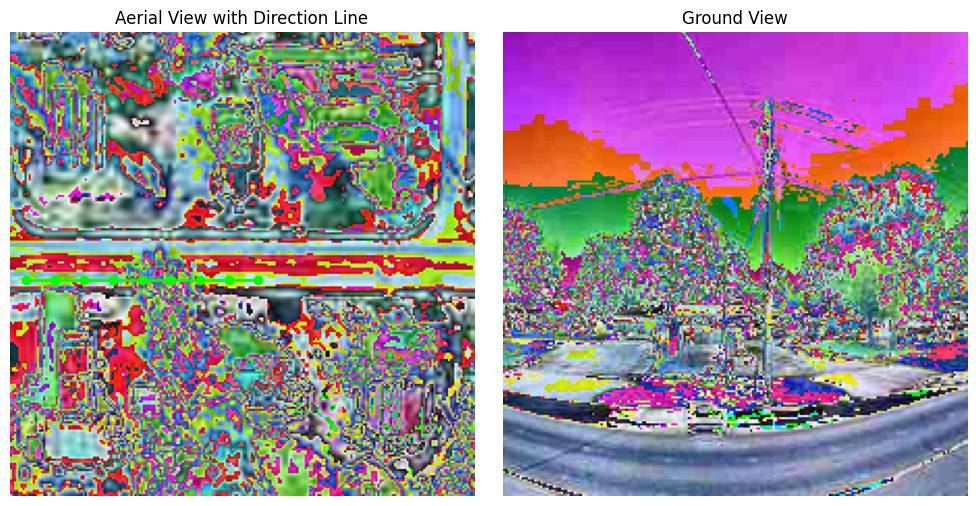

In [12]:
import matplotlib.pyplot as plt

def plot_direction_overlay(aerial_img, ground_img, direction_indices, grid_size=16, color='red'):
    """
    Plots aerial and ground images side by side with direction lines overlayed on the aerial image.
    
    Parameters:
    - aerial_img (ndarray): Aerial image as a numpy array (H x W x 3).
    - ground_img (ndarray): Ground image as a numpy array (H x W x 3).
    - direction_indices (list of (y, x)): List of grid cell coordinates (not pixel coordinates).
    - grid_size (int): Number of grid cells along each axis (e.g., 16).
    - color (str): Line color for overlay.
    """
    # Compute patch size assuming aerial image is evenly divided into grid
    patch_height = aerial_img.shape[0] / grid_size
    patch_width = aerial_img.shape[1] / grid_size

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot aerial image
    axes[0].imshow(aerial_img)
    axes[0].set_title("Aerial View with Direction Line")
    axes[0].axis('off')

    # Convert (y, x) grid indices to image coordinates and draw line
    if direction_indices:
        coords = [
            (
                x * patch_width + patch_width / 2,
                y * patch_height + patch_height / 2
            )
            for y, x in direction_indices
        ]
        xs, ys = zip(*coords)
        axes[0].plot(xs, ys, marker='o', color=color, linewidth=2)

    # Plot ground image
    axes[1].imshow(ground_img)
    axes[1].set_title("Ground View")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

_, indices = get_direction_tokens(tokens=None, angle=180, grid_size=16)
plot_direction_overlay(aerial_image_vis, ground_image_vis, indices, grid_size=16, color='lime')


In [13]:
import gradio as gr
from transformers import AutoImageProcessor, SiglipForImageClassification
from PIL import Image
import torch

# Load model and processor
model_name = "prithivMLmods/IndoorOutdoorNet"  # Updated model name
model = SiglipForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

def classify_environment_image(image):
    """Predicts whether an image is Indoor or Outdoor."""
    image = Image.fromarray(image).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).squeeze().tolist()
    
    labels = {
        "0": "Indoor", "1": "Outdoor"
    }
    predictions = {labels[str(i)]: round(probs[i], 3) for i in range(len(probs))}
    
    return predictions

# Create Gradio interface
iface = gr.Interface(
    fn=classify_environment_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(label="Prediction Scores"),
    title="IndoorOutdoorNet",
    description="Upload an image to classify it as Indoor or Outdoor."
)

# if __name__ == "__main__":
#     iface.launch()


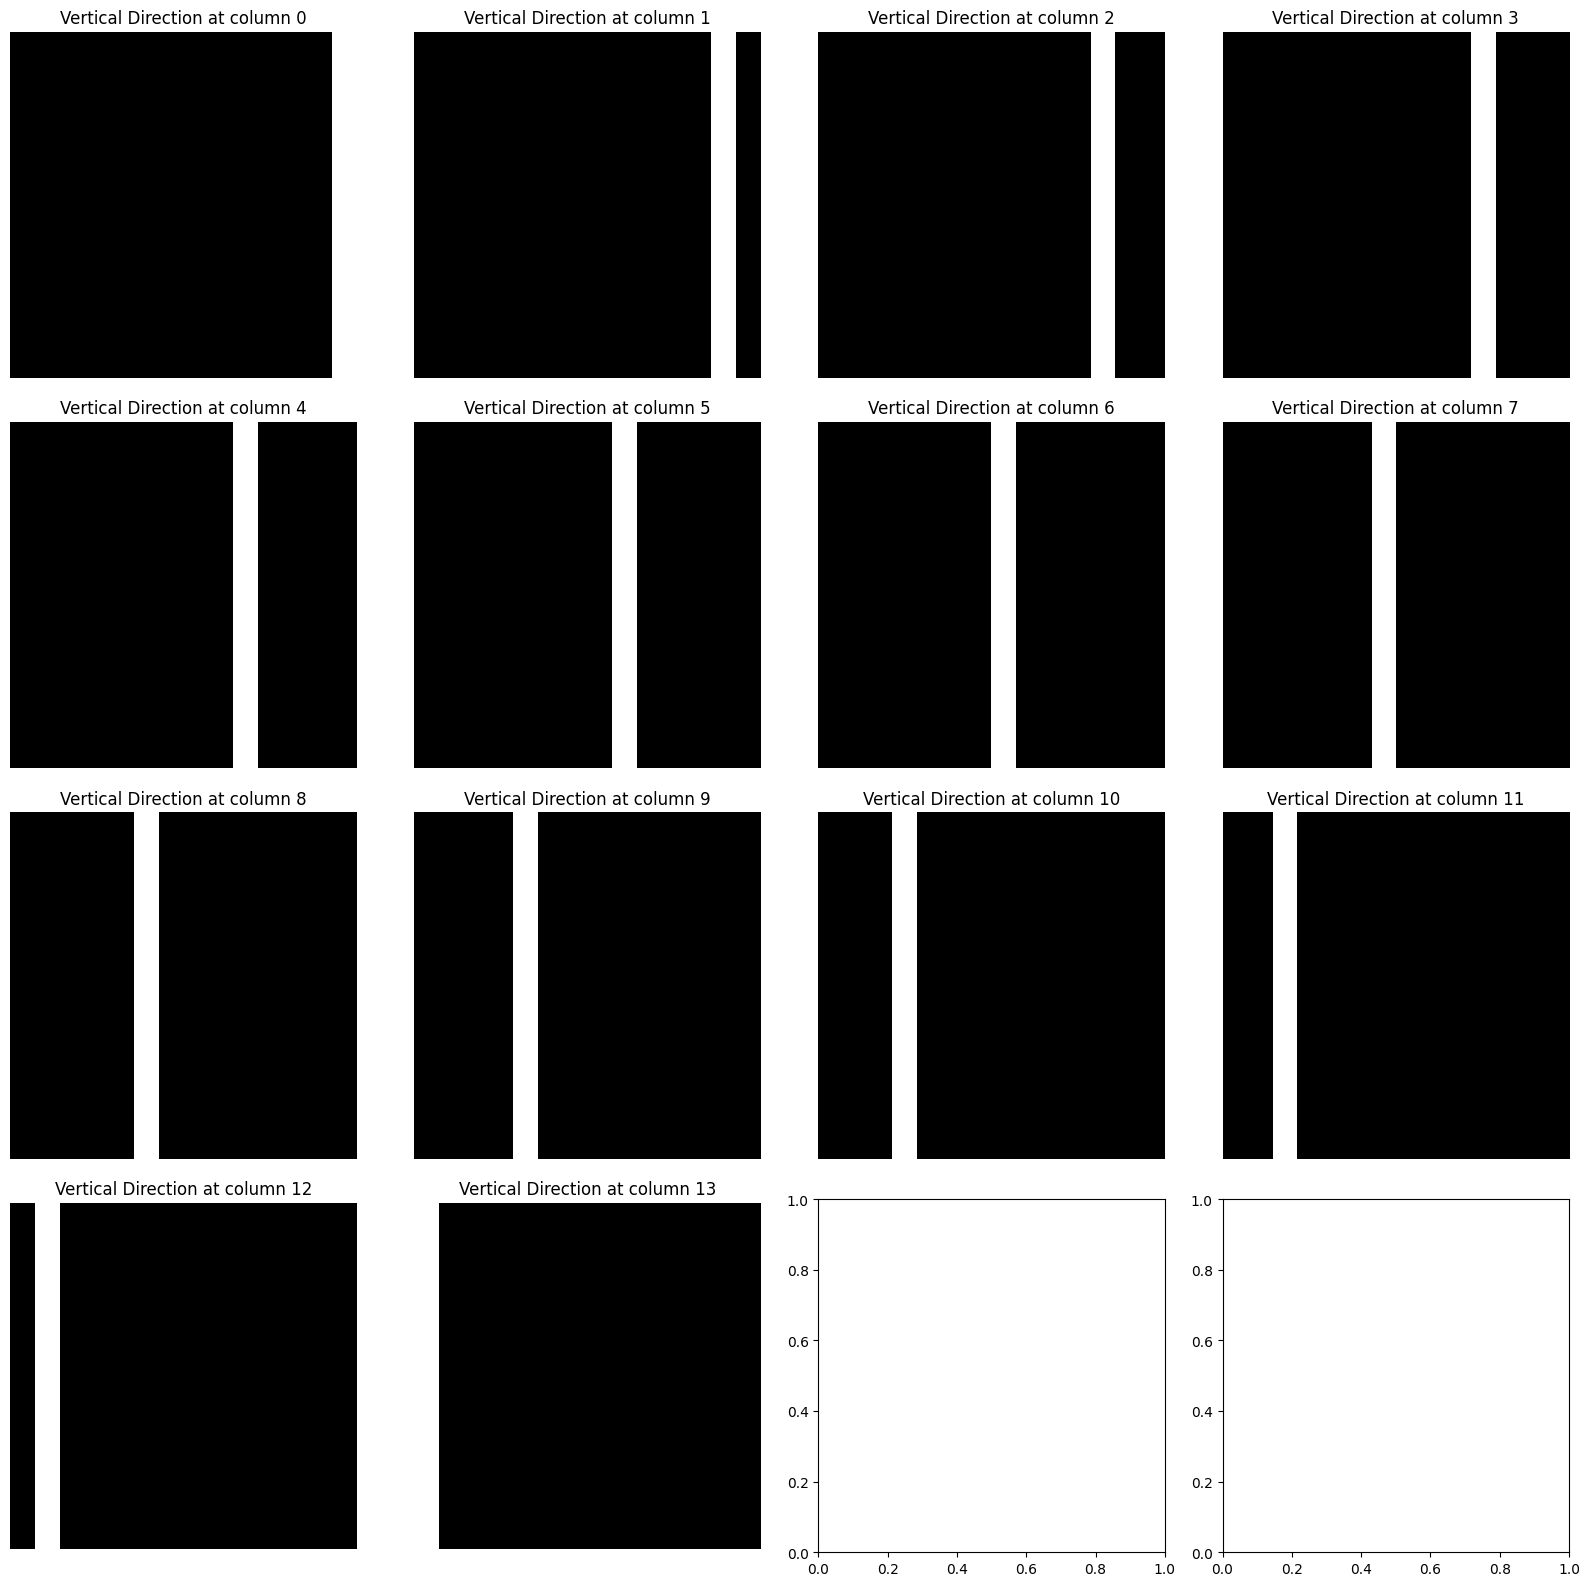

len(angles): 14


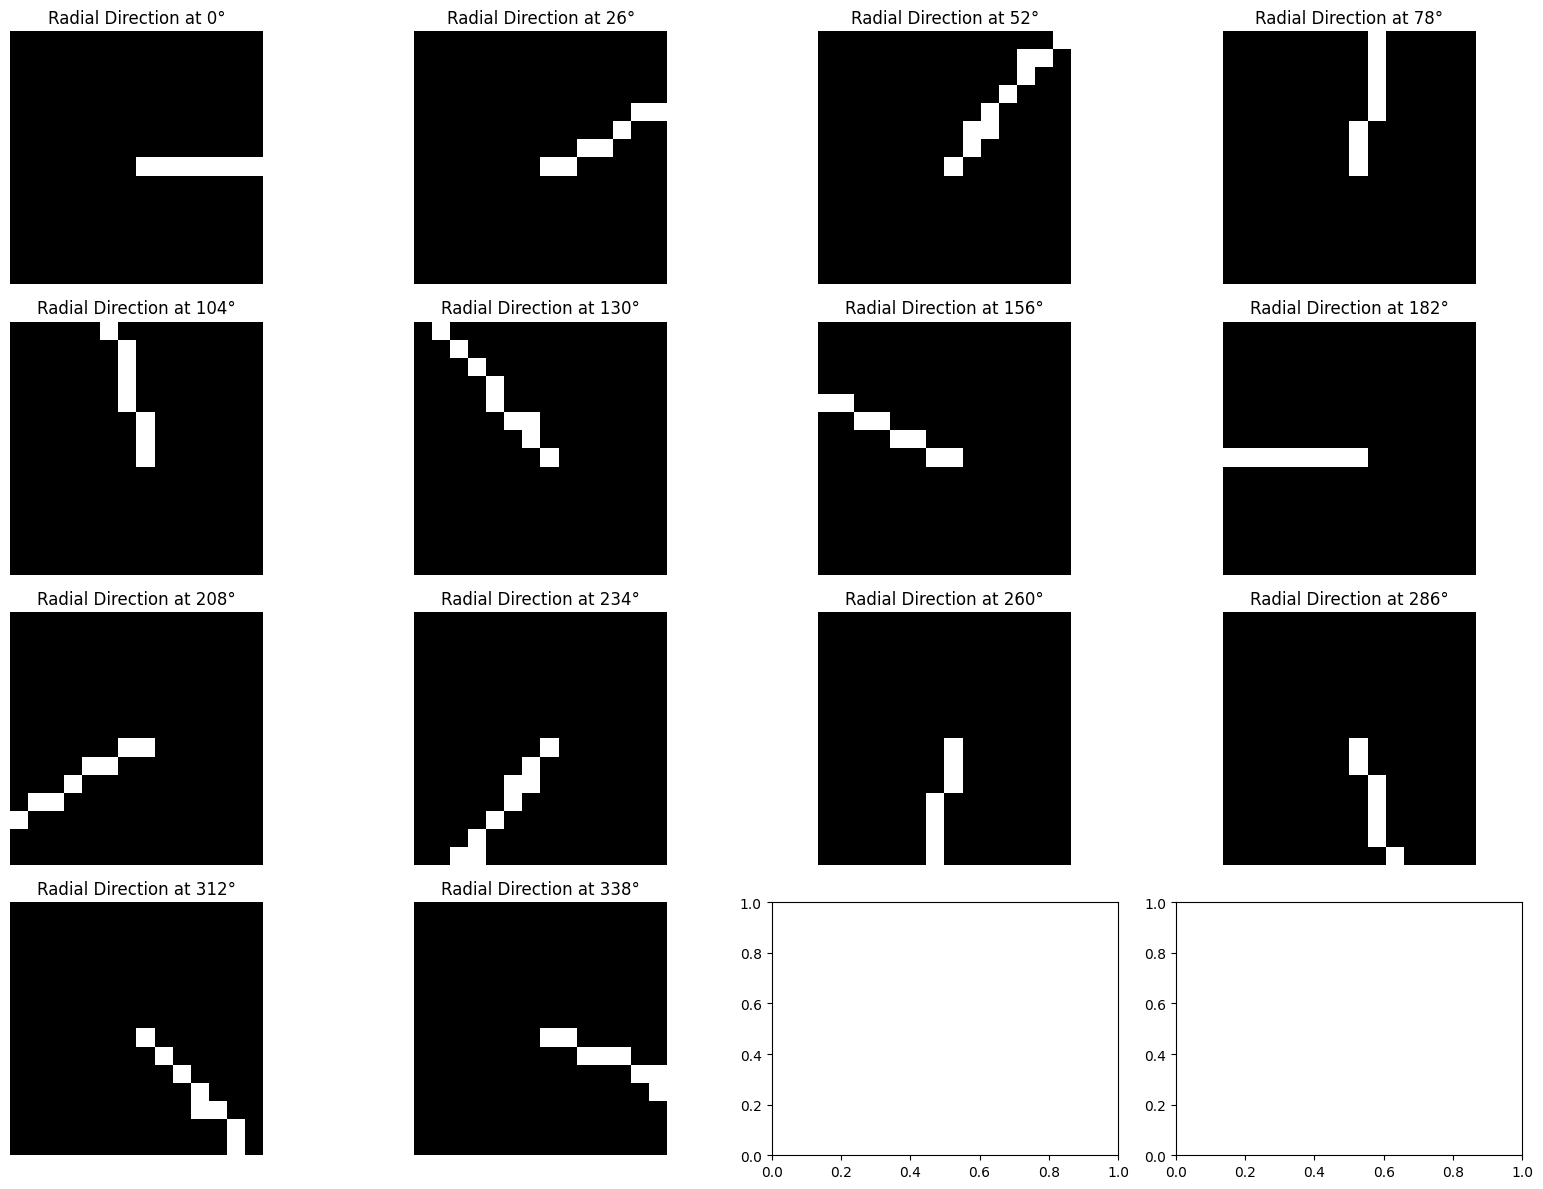

In [14]:
# Visualization of vertical direction tokens
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for i in range(grid_size):
    grid = np.zeros((grid_size, grid_size))
    for y in range(grid_size):
        grid[y, grid_size - 1 - i] = 1  # Highlight the tokens in the vertical direction

    ax = axes[i]
    ax.imshow(grid, cmap='gray')
    ax.set_title(f"Vertical Direction at column {i}")
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join("utils", "vertical_directions.png"), dpi=300, bbox_inches='tight')
plt.show()



# Visualization of radial direction tokens
angles = [angle for angle in range(0, 360-grid_size, round(360/grid_size))]
print("len(angles):", len(angles))
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, angle in enumerate(angles):
    _, indices = get_direction_tokens(normalized_features2, angle=angle, grid_size=grid_size)
    grid = np.zeros((grid_size, grid_size))
    for (y, x) in indices:
        grid[y, x] = 1  # Highlight the tokens in the radial direction

    ax = axes[i]
    ax.imshow(grid, cmap='gray')
    ax.set_title(f"Radial Direction at {angle}°")
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join("utils", "radial_directions.png"), dpi=300, bbox_inches='tight')
plt.show()

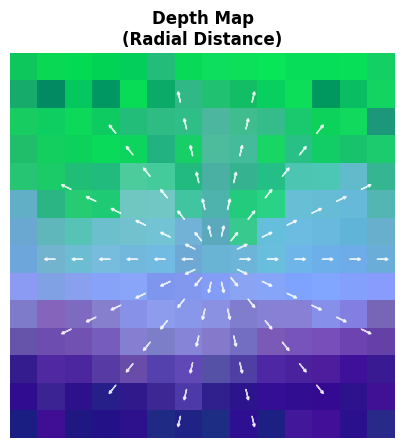

In [15]:
# Tokenized Radial Grid with directional arrows
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(vis_combined1)
# Add radial direction arrows
center_x, center_y = grid_size // 2, grid_size // 2
angles = np.arange(0, 360, 360/grid_size)  # Every 45 degrees
for angle in angles:
    for r in range(1, grid_size // 2):
        x = center_x + r * np.cos(np.deg2rad(angle))
        y = center_y - r * np.sin(np.deg2rad(angle))
        if 0 <= x < grid_size and 0 <= y < grid_size:
            # Draw small arrows
            dx = 0.3 * np.cos(np.deg2rad(angle))
            dy = -0.3 * np.sin(np.deg2rad(angle))
            ax.arrow(x - dx/2, y - dy/2, dx, dy, 
                            head_width=0.1, head_length=0.1, 
                            fc='white', ec='white', alpha=0.8)

ax.set_title('Depth Map\n(Radial Distance)', fontsize=12, fontweight='bold')
ax.axis('off')
plt.show()

In [16]:
from sklearn.preprocessing import normalize

# Normalize the features
normalized_features1 = normalize(tokens_1, axis=1)
normalized_features2 = normalize(tokens_2, axis=1)
print("normalized_features1.shape:", normalized_features1.shape)
print("normalized_features2.shape:", normalized_features2.shape)

# Take one element from features2 (aerial image features)
random_index = np.random.randint(0, tokens_2.shape[0])
selected_feature = normalized_features2[random_index]
print("Selected index from aerial features: ", random_index)

# Show which small piece of the aerial image was chosen
row_aerial, col_aerial = dm.idx_to_source_position(random_index, grid_size2, resize_scale2)
selected_patch_size = dm.model.patch_size * resize_scale2

# Compute the distance (inner product) between this element and all elements of features1 (ground image features)
distances = np.dot(normalized_features1, selected_feature)

# Reshape into the appropriate dimensions for the ground image
reshaped_distances = distances.reshape(grid_size1)

# Resize the heatmap to fit the ground image
resized_heatmap = cv2.resize(reshaped_distances, (ground_image_vis.shape[1], ground_image_vis.shape[0]))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(aerial_image_vis)
rect = plt.Rectangle((col_aerial - selected_patch_size / 2, row_aerial - selected_patch_size / 2),
                     selected_patch_size, selected_patch_size,
                     linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax1.set_title('Selected Patch on Aerial Image')
alpha = 0.5
ax2.imshow(ground_image_vis)
img2 = ax2.imshow(resized_heatmap, cmap='hot', interpolation='nearest', alpha=alpha)
fig.colorbar(img2, ax=ax2)
ax2.set_title('Overlay of Similarity Heatmap on Ground Image')
fig.tight_layout()

normalized_features1.shape: (196, 1024)
normalized_features2.shape: (196, 1024)
Selected index from aerial features:  46


NameError: name 'dm' is not defined